In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats     as stats
import statsmodels.api as sm


from sklearn.model_selection       import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection     import SelectKBest, chi2
from sklearn.metrics               import auc, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.decomposition         import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing         import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import GaussianNB
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.svm          import SVC
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing Data
df = pd.read_csv('Final_Prepared_Data.csv')
df.shape

(39839, 20)

In [3]:
# Encoding variables for modelling

df.Target         = df.Target.map({'Drugs':0, 'Insulin':1})
df.max_glu_serum  = df.max_glu_serum.map({'None': 0, 'Norm':1, '>200':2,'>300':3})
df.A1Cresult      = df.A1Cresult.map({'None': 0, 'Norm':1, '>7':2, '>8':3})

In [4]:
# Creating a KFold Cross Validation Function

def Evaluate(Model_list, x, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    Auc       = []
    Name      = []

    for name,model in Model_list:

        roc_auc   = []
        accur     = []
        Name.append(name)

        for train, test in kf.split(x,y):
            xtrain, xtest = x.iloc[train,:],x.iloc[test,:]
            ytrain, ytest = y.iloc[train],y.iloc[test]

            model.fit(xtrain, ytrain)
            y_predict = model.predict(xtest)
            auc = roc_auc_score(ytest, y_predict)
            roc_auc.append(auc)

        Auc.append(np.mean(roc_auc))

    Report = pd.DataFrame({'AUC Score':Auc}, index=Name)
    return(Report.sort_values('AUC Score', ascending=False))

In [5]:
# Creating a Grid Search function 

def Grid(model, par, x, y):
    GS = GridSearchCV(model, par, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_

# Baseline Model

In [6]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,number_emergency,number_diagnoses,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,Target
0,Caucasian,Female,5,Unknown,Unknown,Referrel,1,41,0,1,0,0,0,1,Other,Other,Other,0,0,0
1,AfricanAmerican,Female,25,Emergency,Home,Emergency,2,11,5,13,2,1,0,6,Other,Diabetes,Other,0,0,0
2,Caucasian,Male,35,Emergency,Home,Emergency,2,44,1,16,0,0,0,7,Other,Other,Circulatory,0,0,1
3,Caucasian,Male,85,Emergency,Home,Emergency,10,55,1,31,0,0,0,8,Circulatory,Circulatory,Circulatory,0,0,1
4,AfricanAmerican,Male,65,Emergency,SC_facility,Emergency,12,75,5,13,0,0,0,9,Injury,Respiratory,Injury,0,0,1


In [7]:
df1 = df.copy()

# Though numerical values age and time in hospital are categorical values
# One-Hot Encoding Categorical values

df1 = pd.get_dummies(df1, columns=['age','time_in_hospital'], drop_first=True)
df1 = pd.get_dummies(df1, drop_first=True)

In [8]:
# Splitting data into train and test

x_base = df1.drop(['Target'],1)
y_base = df1.Target
xtrain_base, xtest_base, ytrain_base, ytest_base = train_test_split(x_base, y_base, test_size=0.3, random_state=0)

In [9]:
# Using a non parametric model as data is not normalised

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)

# Calling Evaluate function
Evaluate([['Baseline_Decision_Tree',tree]], x_base, y_base)

,AUC Score
Baseline_Decision_Tree,0.567805


<Figure size 720x1080 with 0 Axes>

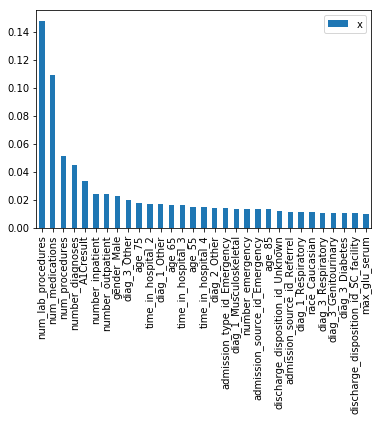

In [10]:
# Inportant Features

imp_feat = pd.DataFrame(tree.feature_importances_, index = x_base.columns, columns= ['x']).sort_values(by='x', ascending=False)
plt.figure(figsize=(10,15))
imp_feat[imp_feat.x >0.01].plot(kind='bar');

In [11]:
# Evaluating other Classifiers

lg  = LogisticRegression()
nb  = GaussianNB()
knn = KNeighborsClassifier()
dt  = DecisionTreeClassifier(random_state=0)
rf  = RandomForestClassifier(random_state=0)

Models = [['Logistic',lg],['Naive_Bayes',nb],['KNN',knn],['DecisionTree',dt],['RandomForest',rf]]
Evaluate(Models, x_base, y_base)

,AUC Score
Logistic,0.609503
Naive_Bayes,0.592473
RandomForest,0.591865
KNN,0.573781
DecisionTree,0.567805


# Outliers Treatment

In [12]:
# Only taking in numerical features

numeric = ['num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_inpatient',
              'number_emergency', 'number_diagnoses']

In [13]:
# Removing Outliers that are 3 STD away

df_outlier = df1[(np.abs(stats.zscore(df1[numeric]))<3).all(axis=1)]

# Normalisation

In [14]:
df2 = df_outlier.copy()

In [15]:
for i in df1[numeric]:   
    print(f'{i:<20} skew : {df1[i].skew()}')

num_lab_procedures   skew : -0.1726919907015699
num_procedures       skew : 1.2767192816540736
num_medications      skew : 1.3282148731589885
number_outpatient    skew : 7.424510208026024
number_inpatient     skew : 3.85188502844125
number_emergency     skew : 12.186440703384932
number_diagnoses     skew : -0.6895999375864704


In [16]:
transform = ['num_procedures', 'num_medications', 'number_outpatient', 'number_inpatient', 'number_emergency']

In [17]:
for i in df2[transform]:
    
    df2[i] = np.sqrt(df2[i])
    print(f'{i:<20} : {df2[i].skew()}')

num_procedures       : 0.3562292595924459
num_medications      : 0.036293593287155694
number_outpatient    : 2.8742859190032437
number_inpatient     : 1.5561763217852764
number_emergency     : 3.9893561775713646


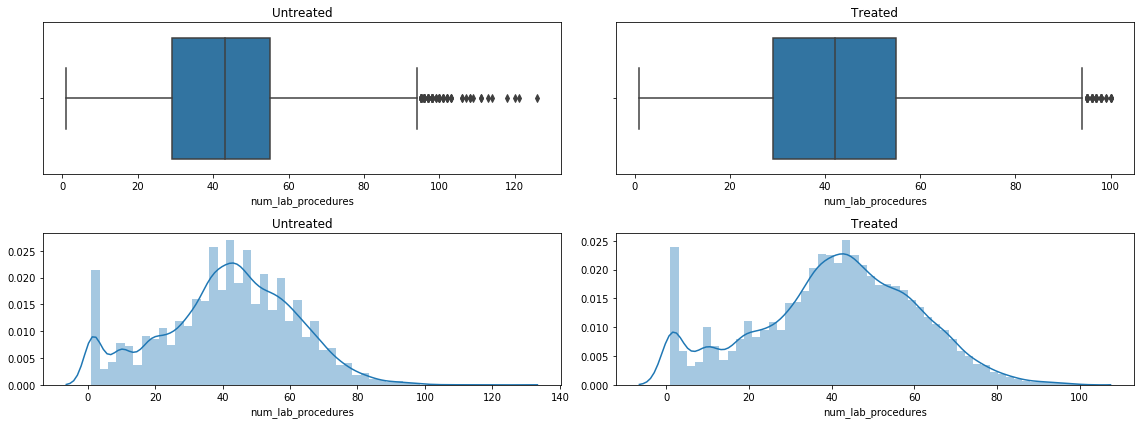

In [18]:
# Number of Lab Procedures

fig, axes = plt.subplots(2,2)
fig.set_figwidth(16)
fig.set_figheight(6)

sns.boxplot(df1.num_lab_procedures, ax=axes[0][0]).set_title('Untreated')
sns.boxplot(df2.num_lab_procedures, ax=axes[0][1]).set_title('Treated')
sns.distplot(df1.num_lab_procedures, ax=axes[1][0]).set_title('Untreated')
sns.distplot(df2.num_lab_procedures, ax=axes[1][1]).set_title('Treated')
plt.tight_layout();

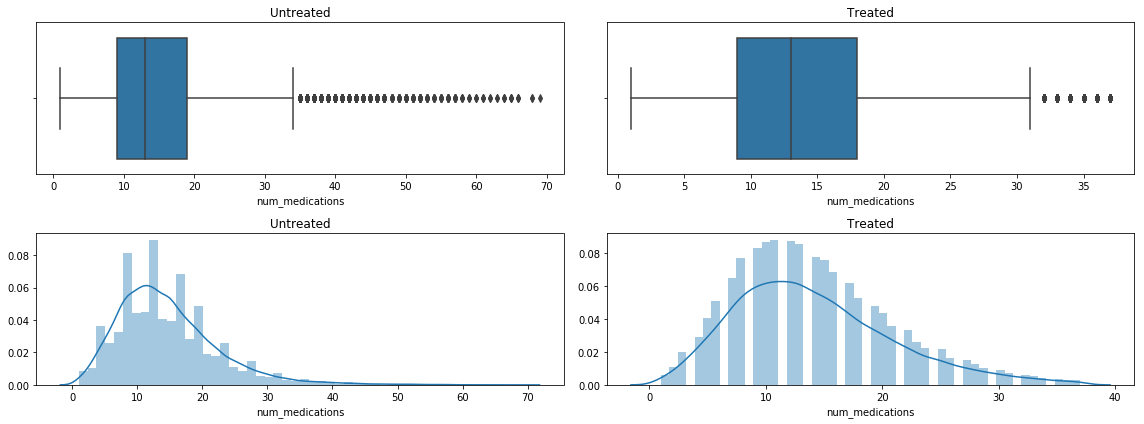

In [19]:
# Number of Medications

fig, axes = plt.subplots(2,2)
fig.set_figwidth(16)
fig.set_figheight(6)

sns.boxplot(df.num_medications, ax=axes[0][0]).set_title('Untreated')
sns.boxplot(df_outlier.num_medications, ax=axes[0][1]).set_title('Treated')
sns.distplot(df1.num_medications, ax=axes[1][0]).set_title('Untreated')
sns.distplot(df_outlier.num_medications, ax=axes[1][1]).set_title('Treated')
plt.tight_layout();

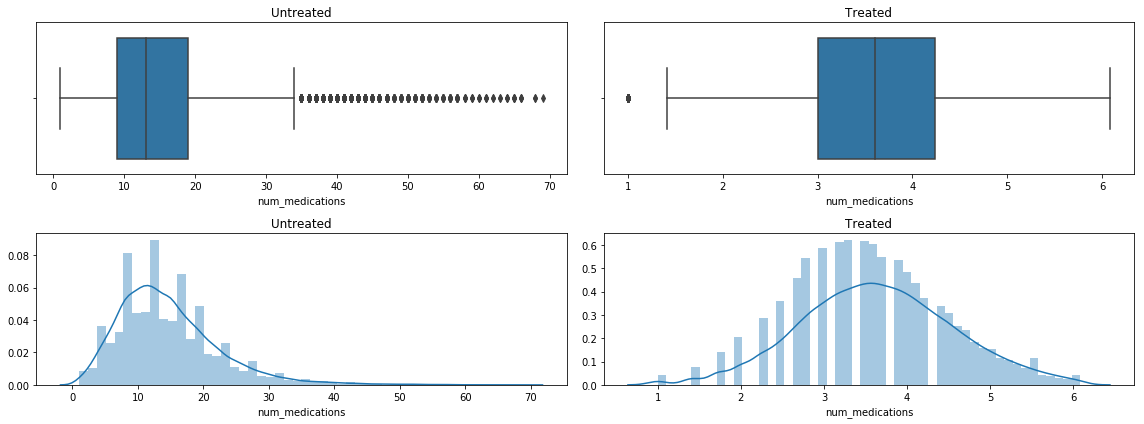

In [20]:
# Number of Medication
fig, axes = plt.subplots(2,2)
fig.set_figwidth(16)
fig.set_figheight(6)

sns.boxplot(df1.num_medications, ax=axes[0][0]).set_title('Untreated')
sns.boxplot(df2.num_medications, ax=axes[0][1]).set_title('Treated')
sns.distplot(df1.num_medications, ax=axes[1][0]).set_title('Untreated')
sns.distplot(df2.num_medications, ax=axes[1][1]).set_title('Treated')
plt.tight_layout();

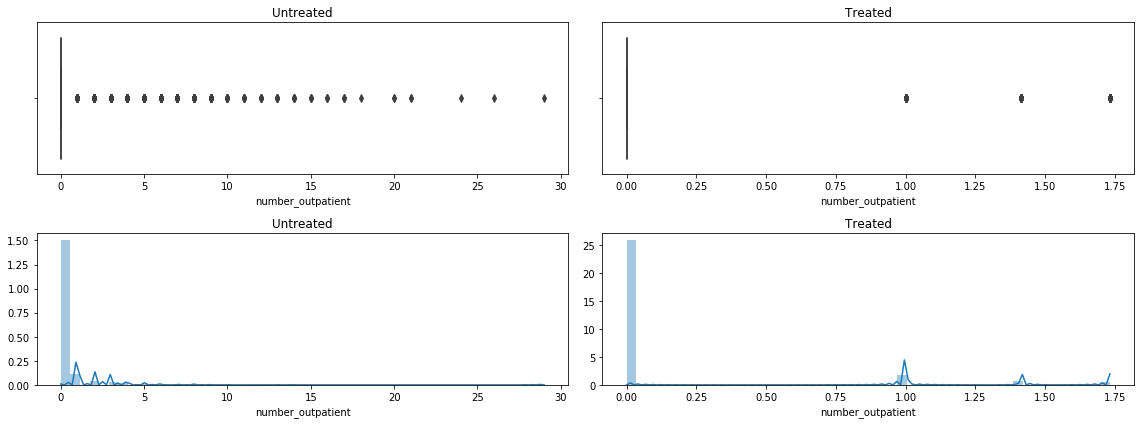

In [21]:
# Number of Outpatient Visits

fig, axes = plt.subplots(2,2)
fig.set_figwidth(16)
fig.set_figheight(6)

sns.boxplot(df1.number_outpatient, ax=axes[0][0]).set_title('Untreated')
sns.boxplot(df2.number_outpatient, ax=axes[0][1]).set_title('Treated')
sns.distplot(df1.number_outpatient, ax=axes[1][0]).set_title('Untreated')
sns.distplot(df2.number_outpatient, ax=axes[1][1]).set_title('Treated')
plt.tight_layout();

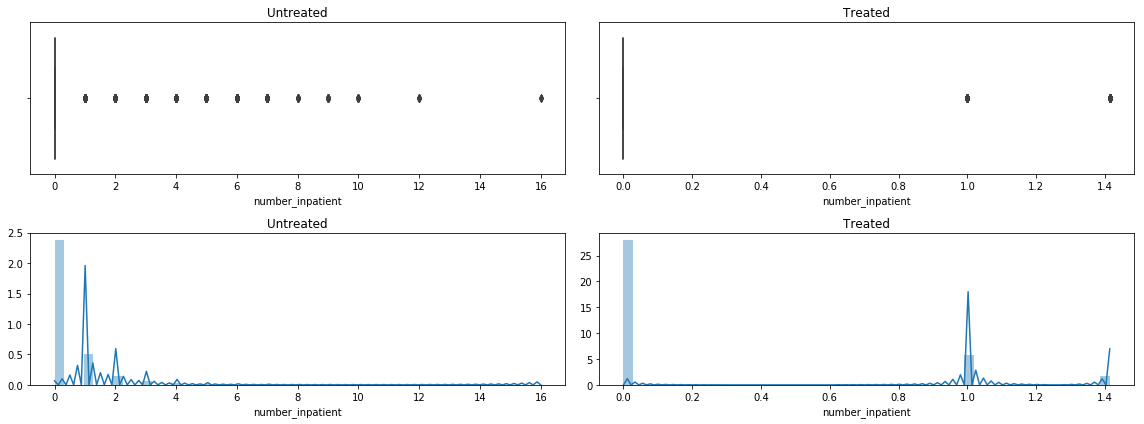

In [22]:
# Number of Inpatient Visits

fig, axes = plt.subplots(2,2)
fig.set_figwidth(16)
fig.set_figheight(6)

sns.boxplot(df1.number_inpatient, ax=axes[0][0]).set_title('Untreated')
sns.boxplot(df2.number_inpatient, ax=axes[0][1]).set_title('Treated')
sns.distplot(df1.number_inpatient, ax=axes[1][0]).set_title('Untreated')
sns.distplot(df2.number_inpatient, ax=axes[1][1]).set_title('Treated')
plt.tight_layout();

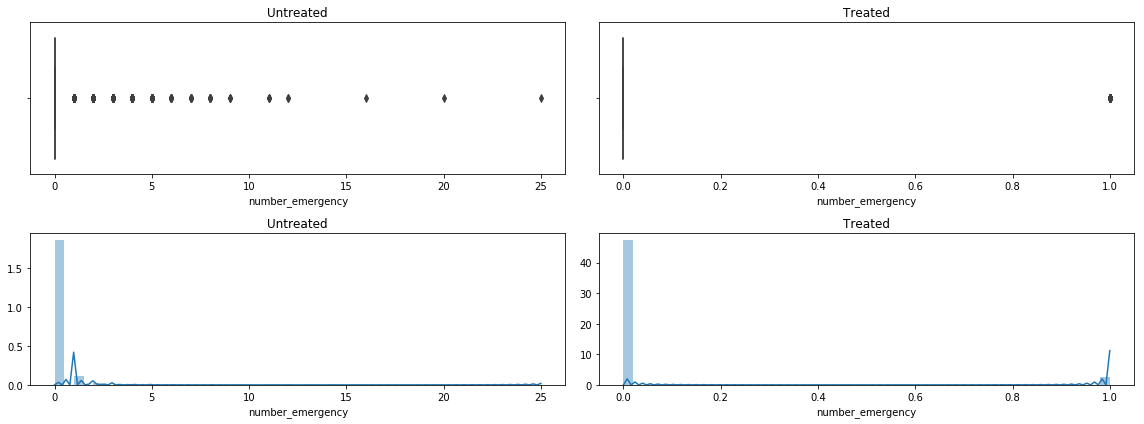

In [23]:
# Number of Emergency Cases

fig, axes = plt.subplots(2,2)
fig.set_figwidth(16)
fig.set_figheight(6)

sns.boxplot(df1.number_emergency, ax=axes[0][0]).set_title('Untreated')
sns.boxplot(df2.number_emergency, ax=axes[0][1]).set_title('Treated')
sns.distplot(df1.number_emergency, ax=axes[1][0]).set_title('Untreated')
sns.distplot(df2.number_emergency, ax=axes[1][1]).set_title('Treated')
plt.tight_layout();

In [24]:
x_normal = df2.drop('Target',1)
y_normal = df2.Target

In [75]:
Evaluate(Models, x_normal, y_normal)

,AUC Score
Logistic,0.598143
Naive_Bayes,0.594865
RandomForest,0.581145
KNN,0.575025
DecisionTree,0.563951


# STATISTICAL TESTING

In [25]:
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfTabular = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0:<25} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX, alpha)

In [26]:
category = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
            'time_in_hospital','diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult']

In [27]:
#Initialize ChiSquare Class
cT = ChiSquare(df)

#Feature Selection
testColumns = df[category]
for var in testColumns:
    cT.TestIndependence(colX=var,colY="Target" )  

race                      is IMPORTANT for Prediction
gender is NOT an important predictor. (Discard gender from model)
age                       is IMPORTANT for Prediction
admission_type_id         is IMPORTANT for Prediction
discharge_disposition_id  is IMPORTANT for Prediction
admission_source_id       is IMPORTANT for Prediction
time_in_hospital          is IMPORTANT for Prediction
diag_1                    is IMPORTANT for Prediction
diag_2                    is IMPORTANT for Prediction
diag_3                    is IMPORTANT for Prediction
max_glu_serum             is IMPORTANT for Prediction
A1Cresult                 is IMPORTANT for Prediction


# Chisquare Analysis on Diagnosis

In [30]:
Diag = df[['diag_1','diag_2','diag_3']]
Diag.head()

,diag_1,diag_2,diag_3
0,Other,Other,Other
1,Other,Diabetes,Other
2,Other,Other,Circulatory
3,Circulatory,Circulatory,Circulatory
4,Injury,Respiratory,Injury


In [31]:
f1 = pd.DataFrame({'Diag': 'diag_1', 'Observation':Diag.diag_1})
f2 = pd.DataFrame({'Diag': 'diag_2', 'Observation':Diag.diag_2})
f3 = pd.DataFrame({'Diag': 'diag_3', 'Observation':Diag.diag_3})

Diagnosis = pd.concat([f1,f2,f3])
Diagnosis.head()

,Diag,Observation
0,diag_1,Other
1,diag_1,Other
2,diag_1,Other
3,diag_1,Circulatory
4,diag_1,Injury


In [32]:
Diag_crosstab = pd.crosstab(Diagnosis.Diag,Diagnosis.Observation)
Diag_crosstab

Observation,Circulatory,Diabetes,Digestive,Genitourinary,Injury,Musculoskeletal,Neoplasm,Other,Respiratory
Diag,,,,,,,,,
diag_1,11465,84,4128,2156,2812,3162,1621,9217,5194
diag_2,12269,2991,1795,3168,1362,1538,1049,11884,3783
diag_3,11683,5558,1629,2384,1286,1570,769,12414,2546


In [33]:
chi_stats2, p_value2, deg_fr2,expected_value2 = stats.chi2_contingency(Diag_crosstab)
print('P_value : ', p_value2, '\nDOF : ',deg_fr2)

P_value :  0.0 
DOF :  16


Since p_value < 0.05, We reject the null hypothesis that there is no significant difference between the Diagnosis.
So all three are considered for modelling

In [38]:
logit = sm.Logit(y_normal, x_normal).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.589641
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                36565
Model:                          Logit   Df Residuals:                    36493
Method:                           MLE   Df Model:                           71
Date:                Wed, 10 Jul 2019   Pseudo R-squ.:                 0.08903
Time:                        23:10:13   Log-Likelihood:                -21560.
converged:                       True   LL-Null:                       -23667.
                                        LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
num_lab_procedures                       0.0018      0.001      2.549      0.011       0.000       0.003
num_procedures                          -0.0452      0.017     -2.694      0.007      -0.078      -0.012
num_medications                          0.4373      0.017     26.312      0.000       0.405       0.470
number_outpatient                       -0.0351      0.031     -1.140      0.254      -0.095       0.025
number_inpatient                         0.2183      0.026      8.467      0.000       0.168       0.269
number_emergency                         0.1872      0.051      3.689      0.000       0.088       0.287
number_diagnoses                         0.0566      0.007      7.715      0.000       0.042       0.071
max_glu_serum                            0.3649      0.037      9.854      0.000       0.292       0.438
A1Cresult                                0.1994      0.014     14.074      0.000       0.172       0.227
age_15                                  -0.3262      0.297     -1.098      0.272      -0.909       0.256
age_25                                  -1.0584      0.275     -3.842      0.000      -1.598      -0.518
age_35                                  -1.8245      0.269     -6.790      0.000      -2.351      -1.298
age_45                                  -2.0533      0.266     -7.713      0.000      -2.575      -1.531
age_55                                  -2.1566      0.266     -8.120      0.000      -2.677      -1.636
age_65                                  -2.2126      0.266     -8.328      0.000      -2.733      -1.692
age_75                                  -2.3502      0.266     -8.845      0.000      -2.871      -1.829
age_85                                  -2.4041      0.267     -9.019      0.000      -2.927      -1.882
age_95                                  -2.4819      0.273     -9.076      0.000      -3.018      -1.946
time_in_hospital_2                      -0.0084      0.041     -0.206      0.837      -0.088       0.071
time_in_hospital_3                      -0.0297      0.042     -0.716      0.474      -0.111       0.052
time_in_hospital_4                      -0.0623      0.046     -1.364      0.173      -0.152       0.027
time_in_hospital_5                      -0.1434      0.051     -2.806      0.005      -0.244      -0.043
time_in_hospital_6                      -0.2097      0.057     -3.685      0.000      -0.321      -0.098
time_in_hospital_7                      -0.1812      0.063     -2.877      0.004      -0.305      -0.058
time_in_hospital_8                      -0.1084      0.071     -1.537      0.124      -0.247       0.030
time_in_hospital_9                      -0.1478      0.083     -1.779      0.075      -0.311       0.015
time_in_hospital_10                     -0.2886      0.093     -3.087      0.002      -0.472      -0.105
time_in_hospital_11                     -0.2684      0.100     -2.692      0.007      -0.46

In [44]:
df3 = df2.copy()
df3.drop(['gender_Male','number_outpatient'],1,inplace=True)

x_tests = df3.drop('Target',1)
y_tests = df3.Target

In [45]:
Evaluate(Models, x_tests, y_tests)

,AUC Score
Logistic,0.598009
Naive_Bayes,0.594940
RandomForest,0.585710
KNN,0.576109
DecisionTree,0.564373


In [75]:
# Evaluate(Models, x_normal, y_normal)

,AUC Score
Logistic,0.598143
Naive_Bayes,0.594865
RandomForest,0.581145
KNN,0.575025
DecisionTree,0.563951


# Feature Selection

In [46]:
select = SelectKBest(k=20)
x_best = pd.DataFrame(select.fit_transform(x_tests, y_tests), columns=x_tests.columns[select.get_support()])

In [47]:
x_best.head()

,num_lab_procedures,num_medications,number_inpatient,number_diagnoses,A1Cresult,age_15,age_25,age_75,race_Caucasian,admission_type_id_Emergency,discharge_disposition_id_SC_facility,discharge_disposition_id_Unknown,admission_source_id_Emergency,admission_source_id_Referrel,diag_1_Musculoskeletal,diag_1_Other,diag_2_Diabetes,diag_2_Other,diag_3_Diabetes,diag_3_Other
0,11.0,3.605551,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,44.0,4.000000,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,55.0,5.567764,0.0,8.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,75.0,3.605551,0.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29.0,3.316625,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [48]:
Evaluate(Models, x_best, y_tests)

,AUC Score
Naive_Bayes,0.593540
Logistic,0.586975
RandomForest,0.579090
KNN,0.573429
DecisionTree,0.558248


# Balancing

In [49]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

X_smote, Y_smote = smt.fit_sample(x_best,y_tests)

x = pd.DataFrame(X_smote, columns=x_best.columns)
y = pd.DataFrame(Y_smote, columns=['target'])

In [50]:
y.target.value_counts()

1    23778
0    23778
Name: target, dtype: int64

In [51]:
Evaluate(Models, x,y)

,AUC Score
RandomForest,0.730114
DecisionTree,0.677928
KNN,0.673417
Logistic,0.629319
Naive_Bayes,0.611099


## Grid Search Parameter Tuning

In [52]:
# Decision Tree

grid_dt = DecisionTreeClassifier(random_state=0)
tree_parameter  = {'criterion':['gini','entropy'],'max_depth':np.arange(1,30)}
Grid(grid_dt, tree_parameter, x, y)

{'criterion': 'entropy', 'max_depth': 14}

In [53]:
# Random Forest

grid_rf = RandomForestClassifier(random_state=0)
rf_parameter  = {'criterion':['gini','entropy'],'max_depth':np.arange(1,20)}
Grid(grid_rf, rf_parameter, x, y)

{'criterion': 'entropy', 'max_depth': 17}

In [55]:
# KNN

grid_knn = KNeighborsClassifier()
knn_parameter  = {'weights':['uniform','distance'],'metric':['minkowski','euclidean']}
Grid(grid_knn, knn_parameter, x, y)

{'metric': 'minkowski', 'weights': 'distance'}

In [56]:
dt  = DecisionTreeClassifier(random_state=0, criterion='entropy'   , max_depth=14)
rf  = RandomForestClassifier(random_state=0, criterion='entropy', max_depth=17)
knn = KNeighborsClassifier(metric= 'minkowski', weights= 'distance')

# Models = [['KNN',knn],['DecisionTree',dt],['RandomForest',rf]]
Best_Models = [['DecisionTree',dt],['RandomForest',rf],['KNN',knn]]
Evaluate(Best_Models, x, y)

,AUC Score
RandomForest,0.732764
KNN,0.705143
DecisionTree,0.684749


# PCA and LDA performing poorly

In [37]:
Evaluate(Best_Models, x_lda, y)

,AUC Score,Accuracy
RandomForest,0.615524,0.615453
DecisionTree,0.614778,0.614611


# Ensemble

In [61]:
bag_dt     = BaggingClassifier(base_estimator=dt ,random_state=0)
boost_dt   = AdaBoostClassifier(base_estimator=dt ,random_state=0)

boost_knn  = BaggingClassifier(base_estimator=knn ,random_state=0)

boost_rf   = AdaBoostClassifier(base_estimator=rf, n_estimators=50 ,random_state=0)

grad_boost = GradientBoostingClassifier(random_state=0)

In [62]:
Boost_Models = [['Bagged_Tree',bag_dt],['Boosted_Tree',boost_dt],
                ['Bagged_KNN',boost_knn],
                ['RF_boost',boost_rf],
                ['Grad_Boost',grad_boost]]

Evaluate(Boost_Models,x,y)

,AUC Score
RF_boost,0.750343
Grad_Boost,0.739201
Bagged_Tree,0.732760
Boosted_Tree,0.704196
Bagged_KNN,0.702279


In [70]:
bag_boost_dt = AdaBoostClassifier(base_estimator=bag_dt ,random_state=0)
Evaluate([['Bag_Boost_Tree', bag_boost_dt]], x, y)

,AUC Score
Bag_Boost_Tree,0.739881


In [63]:
from catboost import CatBoostClassifier

In [65]:
cat = CatBoostClassifier(iterations=250, silent=True, random_state=0)
Evaluate([['CatBoost', cat]], x, y)

,AUC Score
CatBoost,0.758774


In [76]:
stack = VotingClassifier(estimators=[("Cat", cat),('Boost_rf',boost_rf)], voting = 'soft')
Evaluate([['Stacking', stack]], x, y)

,AUC Score
Stacking,0.764205


In [78]:
stack = VotingClassifier(estimators=[("Cat", cat),('Boost_rf',boost_rf),('Bag_boost_dt',bag_boost_dt)], voting = 'soft',
                        weights=[2,2,1])
Evaluate([['Stacking', stack]], x, y)

,AUC Score
Stacking,0.764749


### Based on the AUC Scores, We choose Stacked ensemble of Boosted_Random_forest, Cateegorical_Booster and Gradient_Boost as the best model with an Auc Sore of 76.47 (20% increase from the baseline model)